# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np
import torch.utils.data as data

from torch import nn

from sklearn.model_selection import train_test_split
from lightning import Trainer
from torch.optim.lr_scheduler import StepLR

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    to_bin_labels_mask,
    to_bin_labels,
    to_pu_labels,
    multi_to_bi_class_pu_ds,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.lenet import FullyConvolutionalLeNet, PuLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_numbers_distribution,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    lightning_metrics,
)
from src.util.list_ext import smooth_moving_average
from src.util.loss import PULoss

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 30
scheduler_step_size = num_epochs 
scheduler_gamma = 0.9

In [3]:
batch_size = 64
patch_size = 9
target_dim = 75
examples_per_class = []
smoth_window = 2

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = [20] * num_classes

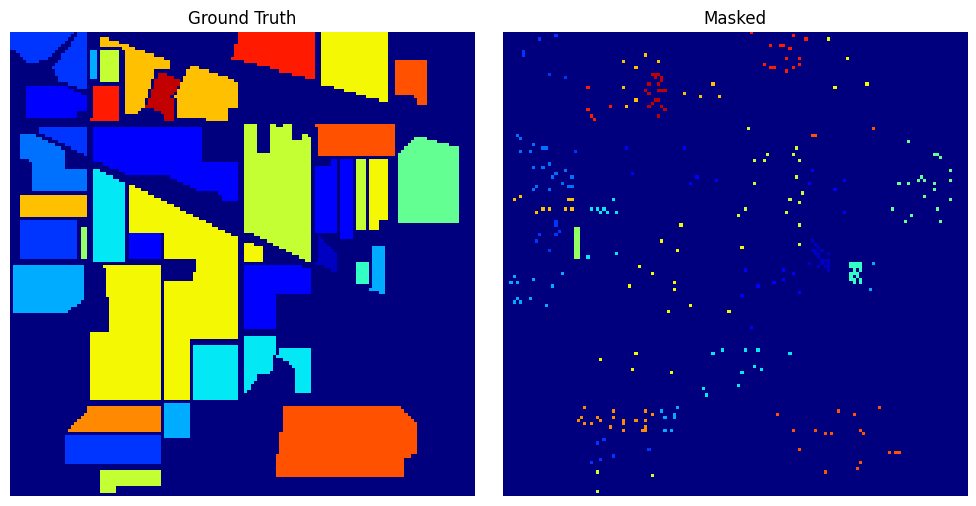

In [14]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w),
        y_masked.reshape(image_h, image_w),
        title2="Masked",
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

x_train, i_y_train, x_test, i_y_test = multi_to_bi_class_pu_ds(
    x_train, y_train, x_test, y_test
)

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)

In [16]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [17]:
full_dataset = data.TensorDataset(x_tensor, y_tensor)

full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

4. Train model

In [18]:
_, counts = torch.unique(y_tensor, return_counts=True)

class_weights = 1.0 / counts 
class_weights = class_weights / class_weights.sum() 

class_weights

tensor([0.0007, 0.1538, 0.0050, 0.0085, 0.0299, 0.0146, 0.0097, 0.2527, 0.0148,
        0.3538, 0.0073, 0.0029, 0.0119, 0.0345, 0.0056, 0.0183, 0.0761])

In [19]:
y_label, y_counts = torch.unique(y_tensor, return_counts=True)
y_counts_sum = counts.sum()

positive_probs = {l.item(): c / y_counts_sum for l, c in zip(y_label, y_counts)}

positive_probs

{0: tensor(0.5125),
 1: tensor(0.0022),
 2: tensor(0.0679),
 3: tensor(0.0395),
 4: tensor(0.0113),
 5: tensor(0.0230),
 6: tensor(0.0347),
 7: tensor(0.0013),
 8: tensor(0.0227),
 9: tensor(0.0010),
 10: tensor(0.0462),
 11: tensor(0.1168),
 12: tensor(0.0282),
 13: tensor(0.0098),
 14: tensor(0.0602),
 15: tensor(0.0184),
 16: tensor(0.0044)}

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


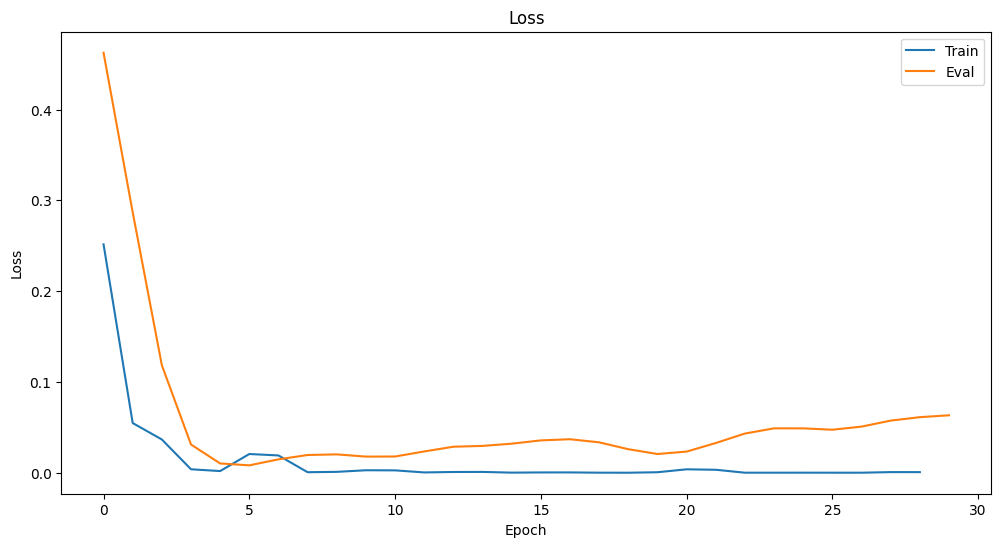

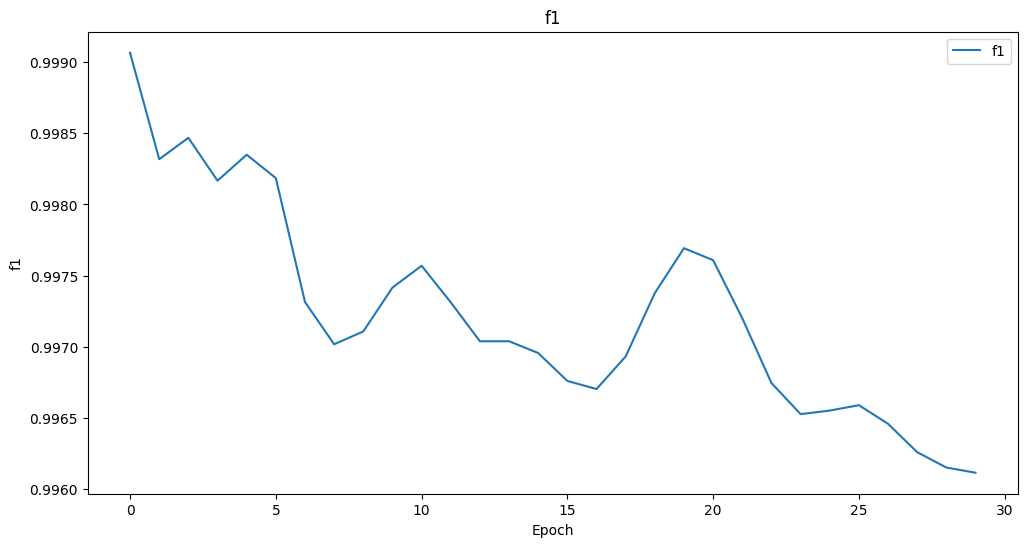

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

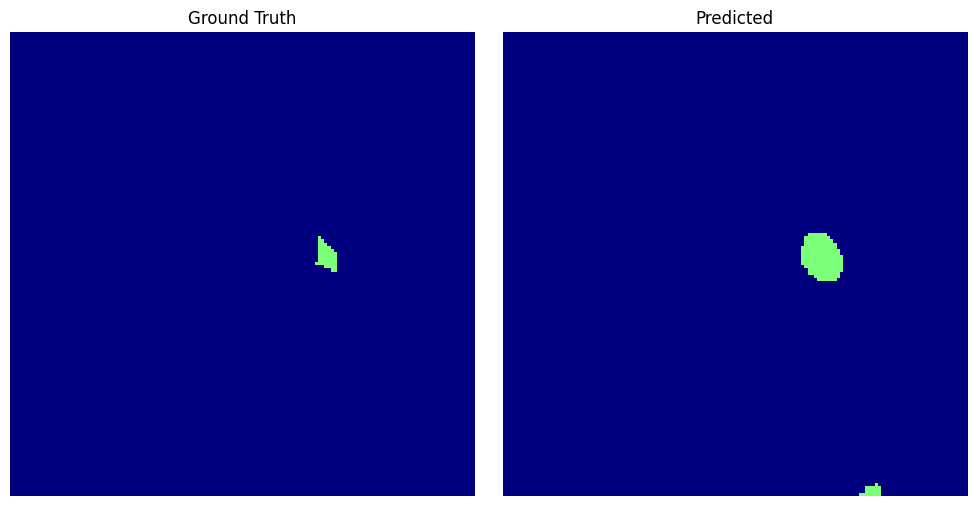

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


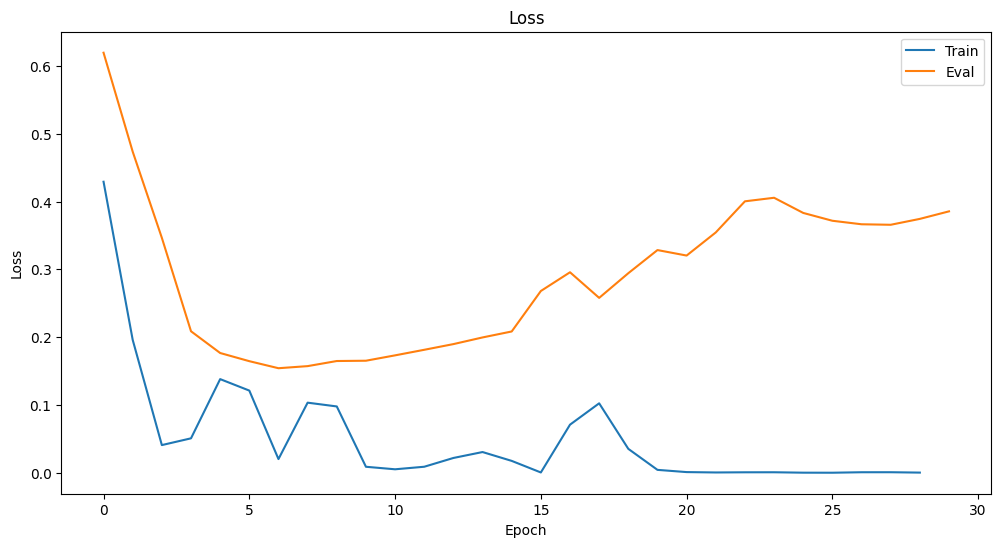

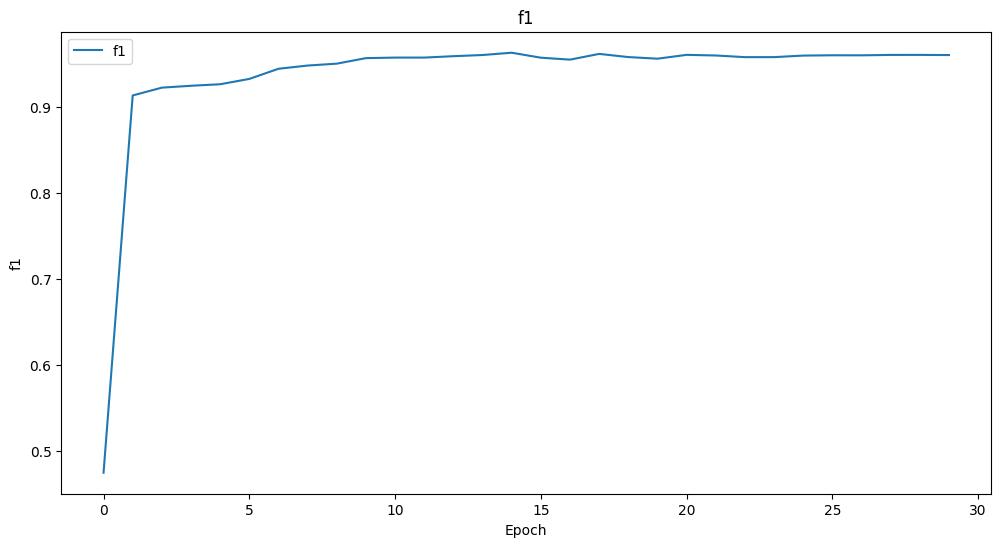

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

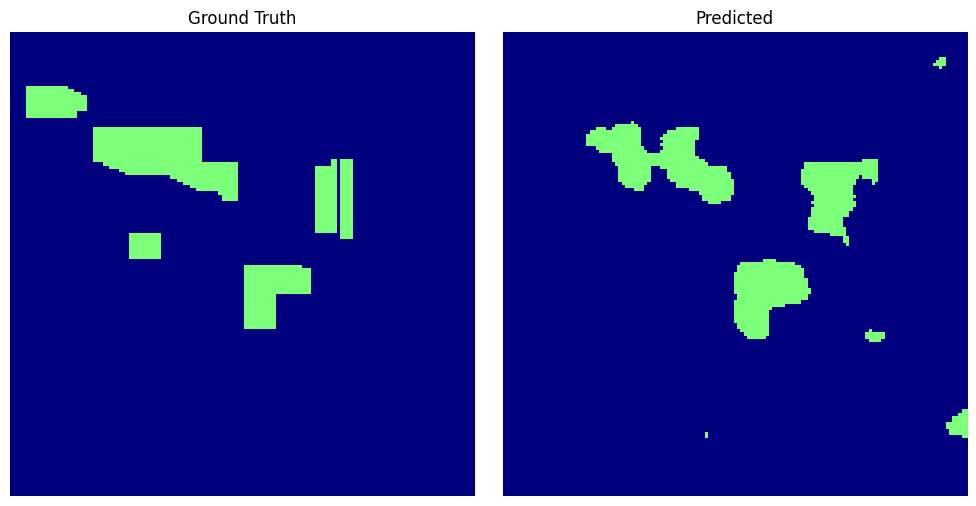

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


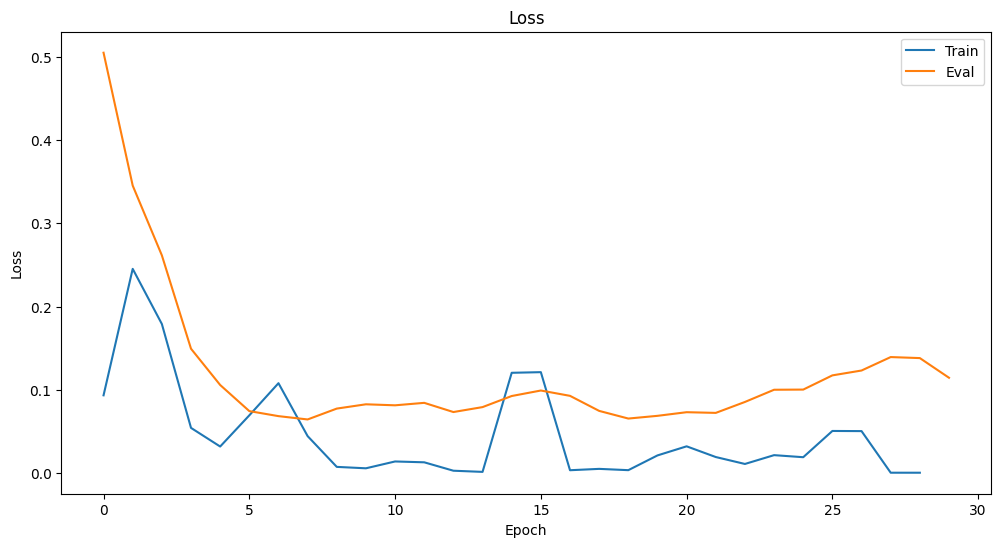

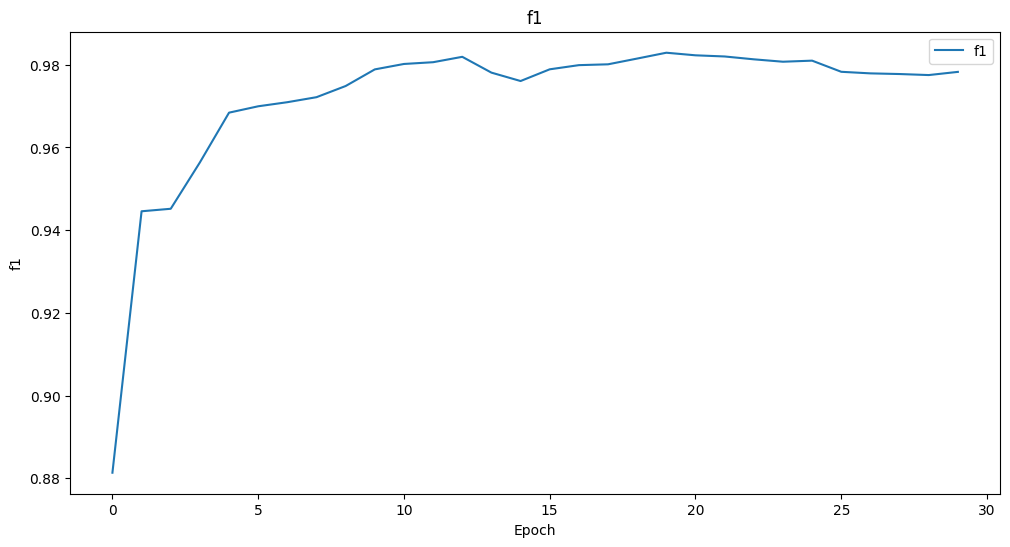

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

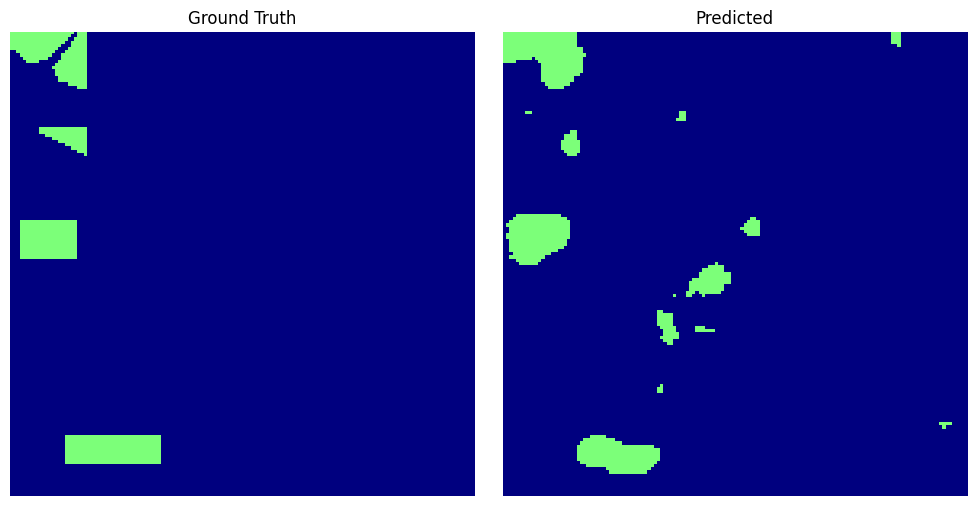

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


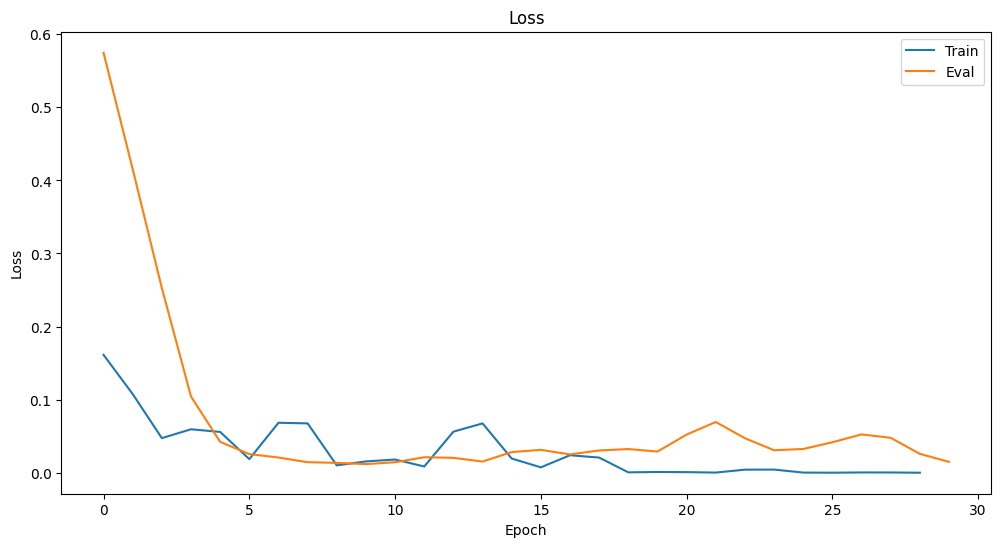

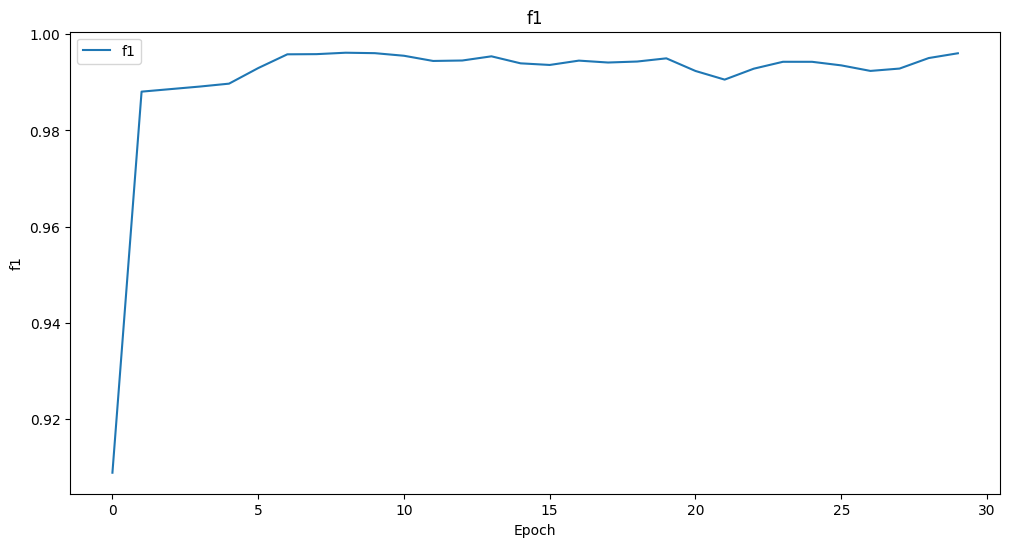

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

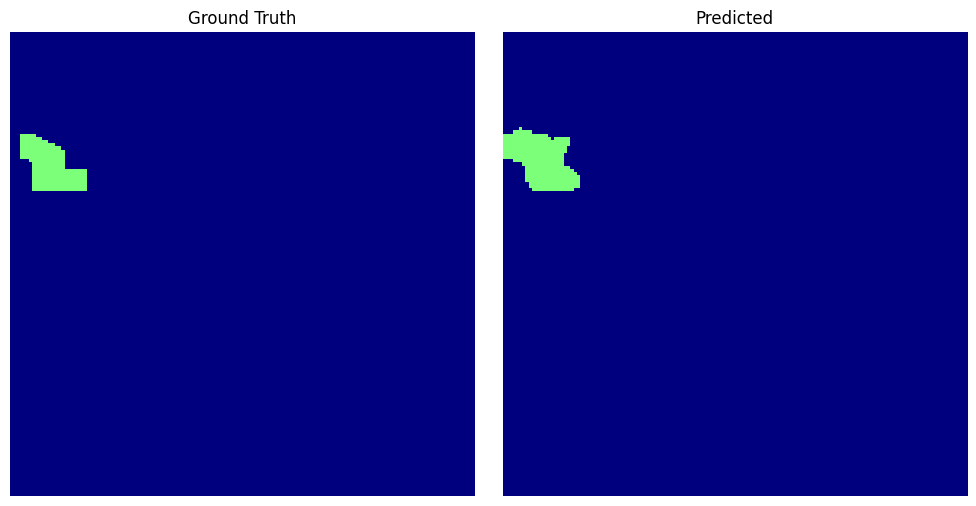

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


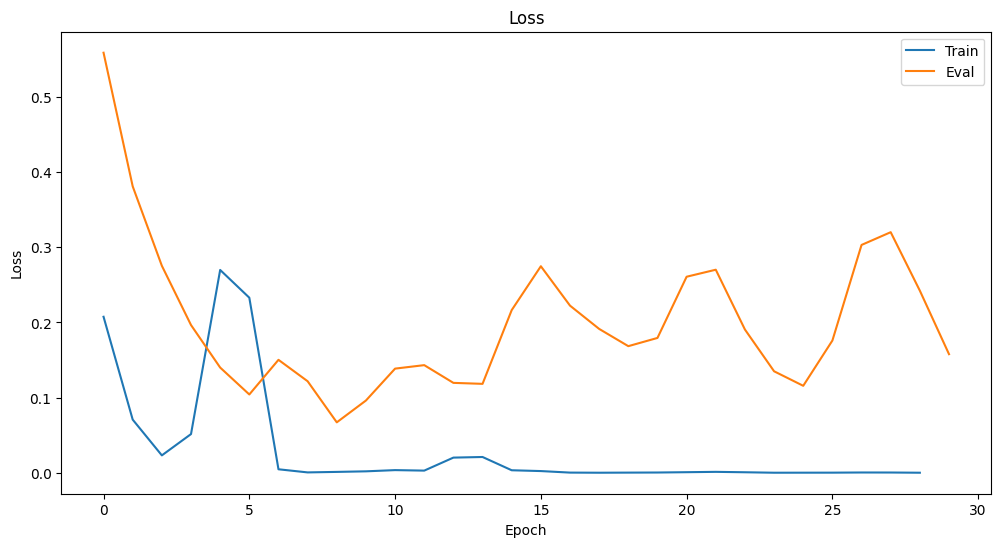

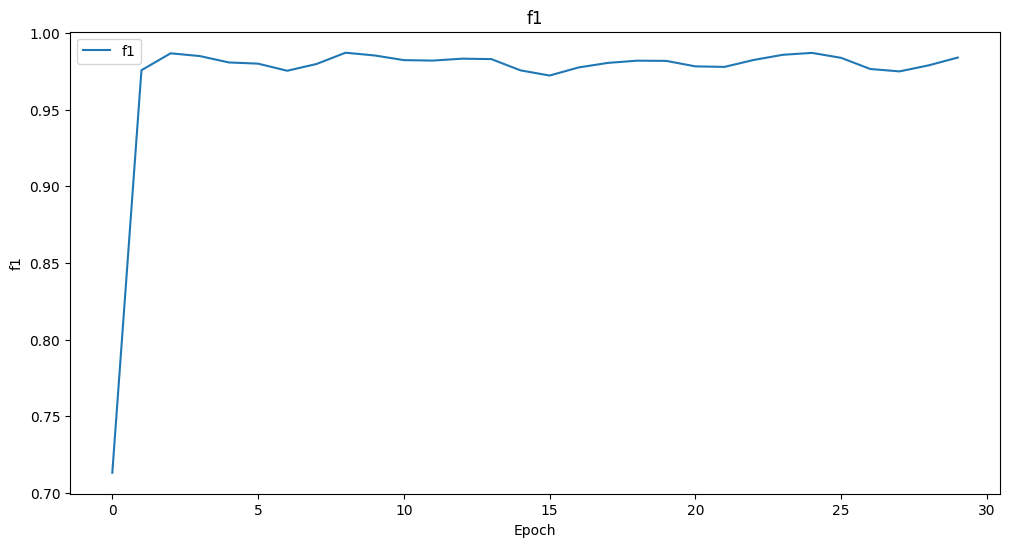

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

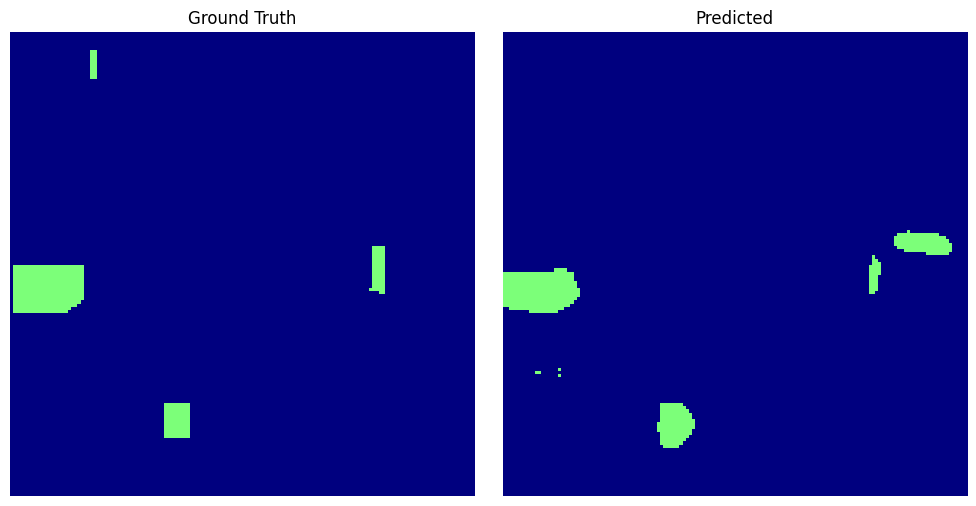

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


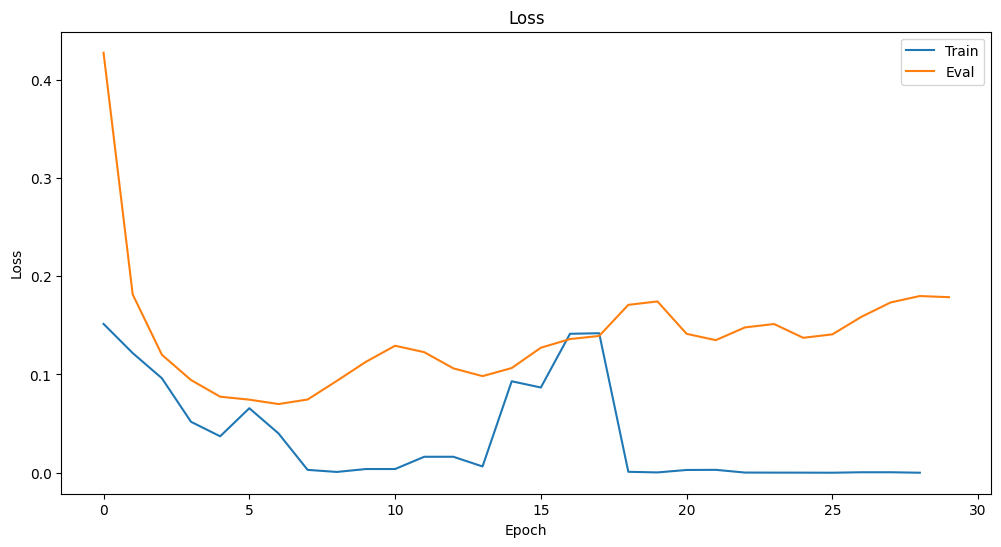

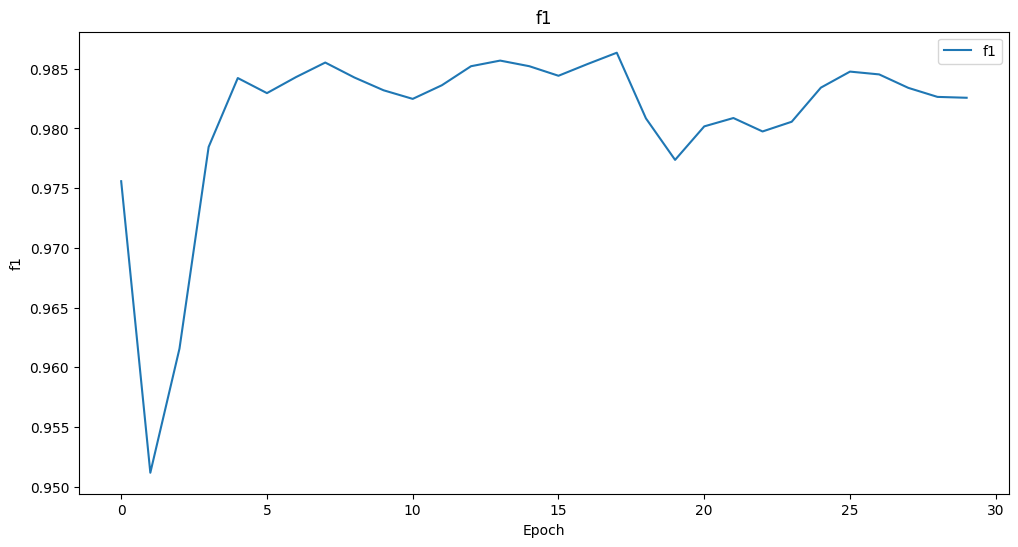

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

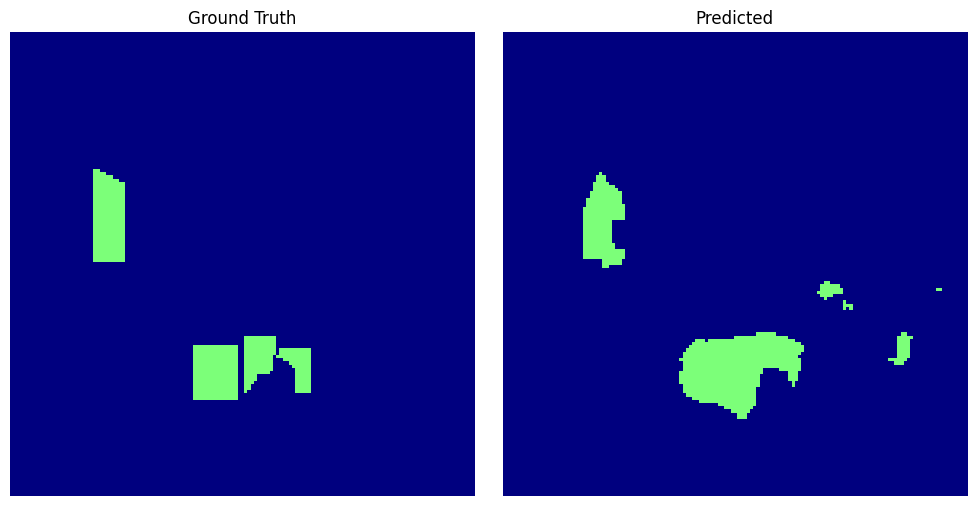

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


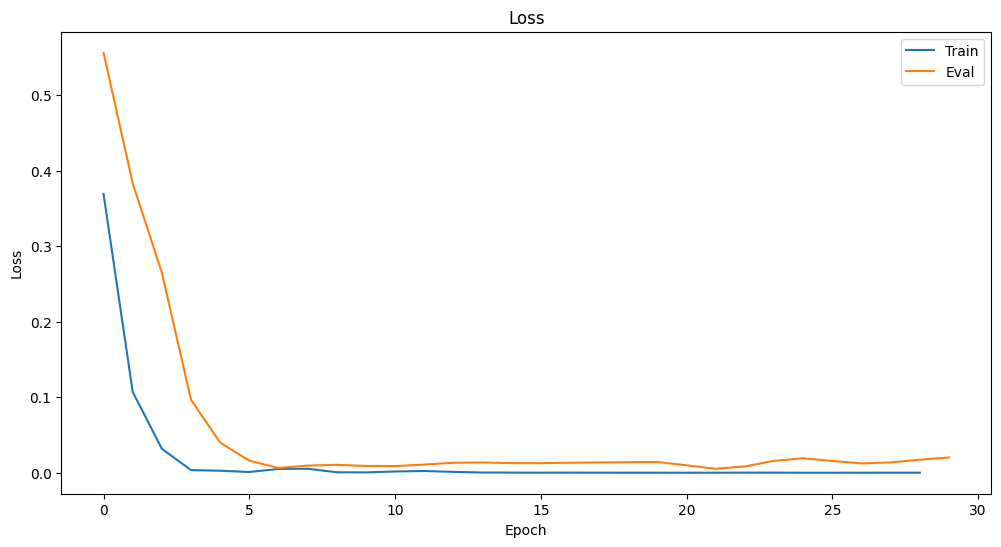

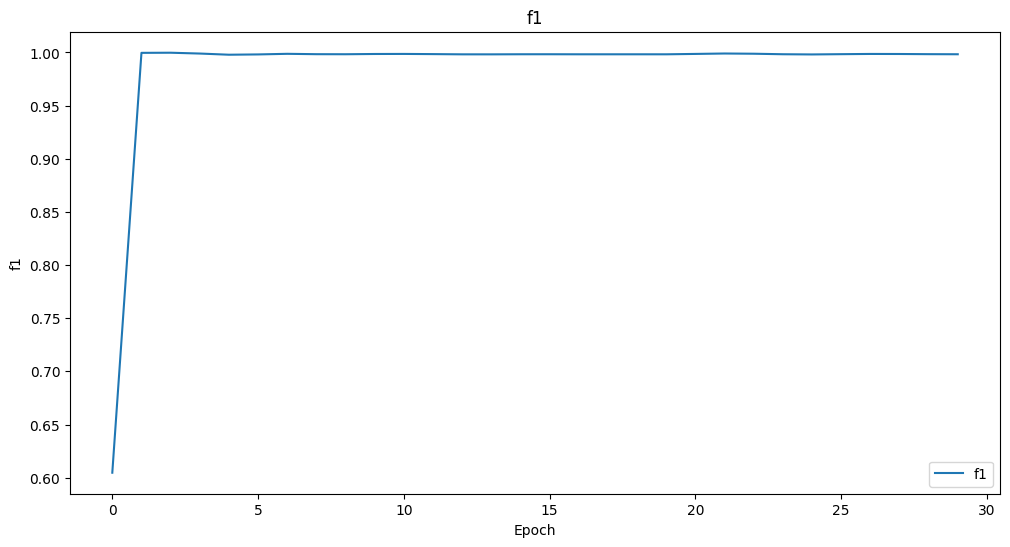

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

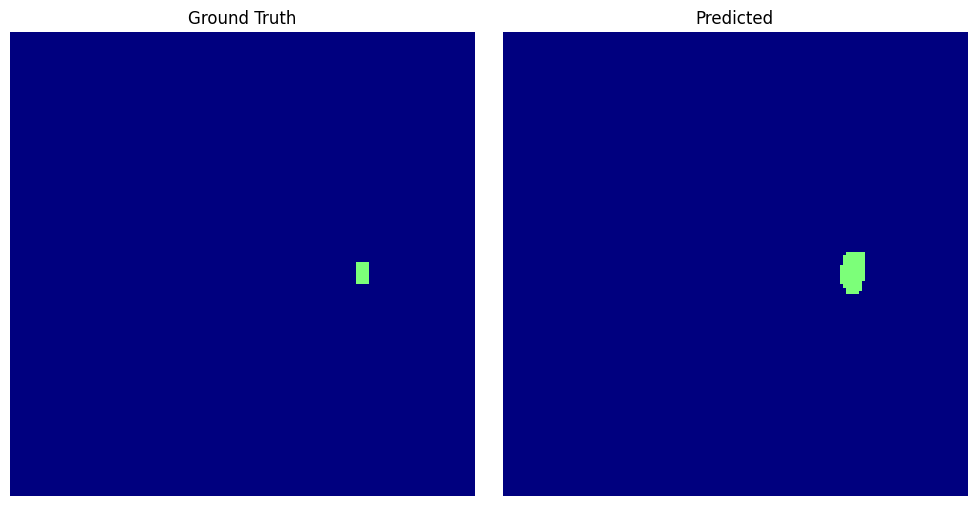

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from src.model.dbda import DBDA


models = []

for i in range(1, num_classes):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(i_y_train[i], dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(i_y_test[i], dtype=torch.long)
    train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=cpu_count,
        persistent_workers=True,
    )
    test_loader = data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=cpu_count,
        persistent_workers=True,
    )

    loss_fun = PULoss(prior=positive_probs[i])

    backbone = DBDA(
        band=target_dim,
        classes=2,
    )

    # pred_extractor = lambda logits: (torch.sigmoid(logits) > 0.5).int()
    pred_extractor = lambda logits: torch.argmax(logits, dim=1)

    model = HyperSpectralImageClassifier(
        backbone,
        2,
        lr=learning_rate,
        # loss_fun=loss_fun,
        # scheduler=lambda opt: StepLR(
        #     opt, step_size=scheduler_step_size, gamma=scheduler_gamma
        # ),
        # pred_extractor=pred_extractor,
    )

    trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

    trainer.fit(
        model,
        train_loader,
        test_loader,
    )

    models.append(model)

    smothed_train = smooth_moving_average(
        [it.loss.cpu() for it in model.train_metrics], smoth_window
    )
    smothed_eval = smooth_moving_average(
        [it.loss.cpu() for it in model.val_metrics], smoth_window
    )

    plot_epoch_generic_comparison(smothed_train, smothed_eval)

    smooth_f1 = smooth_moving_average(
        [it.f1.cpu() for it in model.val_metrics], smoth_window
    )

    plot_epoch_generic(smooth_f1, desc="f1")

    y_pred = trainer.predict(model, predict_loader)

    y_pred = torch.cat(y_pred, dim=0)
    y_pred = pred_extractor(y_pred)
    y_pred = y_pred.reshape(image_h, image_w)

    y_true = np.zeros_like(y)
    y_true[y == i] = 1

    plot_segmentation_comparison(y_true.reshape(image_h, image_w), y_pred.numpy())

In [ ]:
validation_result = trainer.validate(model, full_loader)

validation_result

5. Display prediction

In [ ]:
y_pred = trainer.predict(model, predict_loader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = pred_extractor(y_pred)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy())

6. Write report

In [ ]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "bin_lenet"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Default run",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=lightning_metrics(validation_result),
)

In [ ]:
read_report_to_show(model_name, sort_by_metric="f1")

In [ ]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)